# ARIM-Academy：　機器データ利活用ユースケース
### タイトル：茶の抽出条件に関する機械学習/数学的最適化検討
### 機器：誘導結合プラズマ発光分光分析法（ICP-OES）
### 分析：次元削減、クラスタ分析


## データセット

    
本編で扱う 『茶の元素分析データセット』（data.xlsx）、は、ブラックセイロン(BC)、ブラックトルコ(BT)、グリーンセイロン(GC)、グリーントルコ(GT)の4種類の茶葉について、3つの濃度（1%、2%、3%）で抽出したサンプルの誘導結合プラズマ発光分光分析法（ICP-OES）の元素分析データです。[1]

この研究では、機械学習（回帰分析としてMLR, ANN、および主成分分析、ISOMAP、階層クラスタ分析など）の手法を使い、茶の品種、濃度、浸出時間によるミネラル組成の変化を調査し、特定のミネラルレベルを調整する条件を見つける検討が行われています。

[1] Durmus, Y., Atasoy, A.D. & Atasoy, A.F. Mathematical optimization of multilinear and artificial neural network regressions for mineral composition of different tea types infusions. Sci Rep 14, 18285 (2024). https://doi.org/10.1038/s41598-024-69149-1

---
<br>  
<img src="./img/main_image.jpg" width="50%">
<br> 

---

**Chemical composition** 
* 9種類の元素分析値（Al, Ca, Cu, Fe,K,Mg,Mn,Na,Zn） 

**Experimental parameters**  
* Concentration：　お茶の濃度
* time:　抽出時間

**Label**
* grouped:　品種・色・濃度・抽出時間を識別できる一種の飼料名（MLは使用せず） 
* teaConc:　濃度ラベル（MLは使用せず）
* tea_org:　色ラベル（MLは使用せず）
* tea_var:　品種ラベル（MLは使用せず）
* tea：　　 色と品種ラベル（MLで使用）

### 教材への接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!git clone https://github.com/ARIM-Usecase/Example_2.git
%cd Example_2

### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
# 汎用ライブラリ
import pandas as pd
import matplotlib.pyplot as plt

# 機械学習
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

## 1.データセットの読み込みと前処理

### サンプルファイルの読み込み
pandasライブラリのread_excel()関数は、Excelファイルを読み込んでpandasのDataFrame形式に変換する関数です。ここでは[data]フォルダーにあるdata.xlsxファイルをDataFrameとして読み込み、その結果をdfという変数に格納します。168のサンプルに対して16の特徴量からなるデータ行列となっています。

In [32]:
# データの読み込み
df = pd.read_excel('./data/data.xlsx',header = 1)
df

,Al,Ca,Cu,Fe,K,Mg,Mn,Na,Zn,grouped,tea,Concentration,time,teaConc,tea_org,tea_var
0,3.297,4.356,0.031290,0.067,99.06,3.531,1.455,0.541,0.131,Black Turkish 1 2,BT,1,2,BT1,black,turki
1,4.267,4.118,0.031290,0.079,106.50,3.378,1.542,0.603,0.126,Black Turkish 1 2,BT,1,2,BT1,black,turki
2,4.088,4.763,0.033370,0.084,114.00,4.763,1.838,1.058,0.156,Black Turkish 1 5,BT,1,5,BT1,black,turki
3,4.338,4.556,0.033370,0.091,122.60,5.005,2.269,0.958,0.162,Black Turkish 1 5,BT,1,5,BT1,black,turki
4,4.732,5.138,0.035514,0.110,132.40,5.626,2.998,1.510,0.165,Black Turkish 1 10,BT,1,10,BT1,black,turki
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,16.690,8.895,0.153000,0.236,323.40,20.450,10.420,6.360,0.335,Green Ceylan 3 30,GC,3,30,GC3,green,ceylon
164,17.620,8.909,0.177000,0.261,334.20,23.486,11.330,7.133,0.351,Green Ceylan 3 45,GC,3,45,GC3,green,ceylon
165,17.920,9.056,0.180000,0.266,332.30,22.840,11.290,7.609,0.358,Green Ceylan 3 45,GC,3,45,GC3,green,ceylon
166,17.820,9.128,0.175000,0.273,367.30,24.560,12.110,8.537,0.372,Green Ceylan 3 60,GC,3,60,GC3,green,ceylon


In [35]:
# ミネラルデータの抽出
minerals = ['Al', 'Ca', 'Cu', 'Fe', 'K', 'Mg', 'Mn', 'Na', 'Zn']
X = df[minerals] # ミネラル成分
y = df["tea"]    # 品種（ラベル）

## 2.　前処理
### 標準化  
モデルはデータのスケールに敏感であるため、次元削減を行う前にデータを標準化することが重要です。標準化とは、各特徴量を平均0、標準偏差1にスケーリングする手法で、異なるスケールを持つ特徴量を均等に扱えるようにします。これにより、モデルが特徴量のスケールに影響されず、データ全体の構造を正確に反映することが可能になります。

標準化は、pythonではScikit-learnライブラリで提供されている`StandardScaler`クラスで、データの標準化を簡単に行うことができます。

In [36]:
# データの標準化
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## 3.機械学習（次元削減）
### 3.1 scikit-learnによる主成分分析（PCA）
PCA()クラスは、Scikit-learnライブラリが提供するクラスで、主成分分析を行うために使用されます。

In [37]:
# 主成分分析（PCA）で2次元に次元削減
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_std)

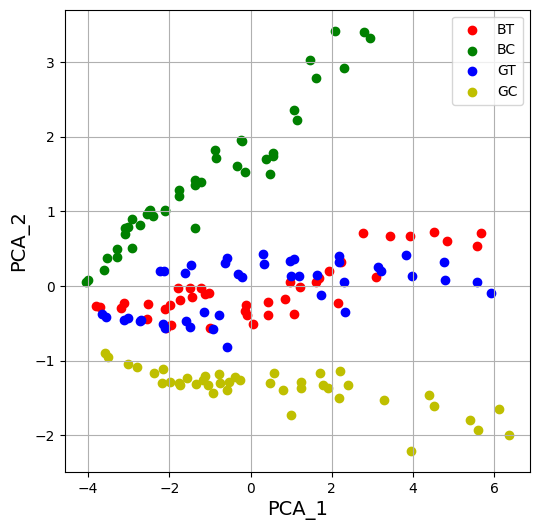

In [38]:
# PCAのプロット
plt.figure(figsize=(6, 6))

colors = ['r', 'g', 'b','y']
species = ['BT', 'BC', 'GT','GC']

for color, specie in zip(colors, species):
    plt.scatter(X_pca[y == specie, 0], X_pca[y == specie, 1], 
                label=specie, 
                color=color
               )

plt.xlabel('PCA_1', fontsize =14)
plt.ylabel('PCA_2', fontsize =14)


plt.legend()
plt.grid()
plt.show()

### 3.2 scikit-learnによるISOMAP分析
Isomap()クラスは、Scikit-learnライブラリが提供するクラスで、Isomap分析を行うために使用されます。

In [39]:
# ISOMAPの実行
isomap = Isomap(n_neighbors=5, n_components=2, metric='euclidean')
X_isomap = isomap.fit_transform(X_std)


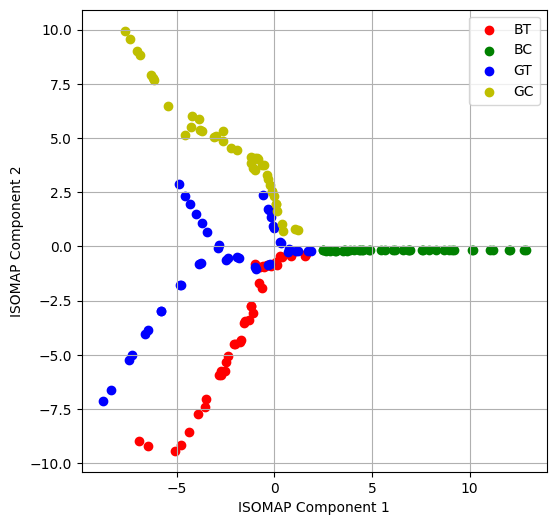

In [40]:
# ISOMAPの結果をプロット
plt.figure(figsize=(6, 6))

colors = ['r', 'g', 'b','y']
species = ['BT', 'BC', 'GT','GC']

for color, specie in zip(colors, species):
    plt.scatter(X_isomap[y == specie, 0], X_isomap[y == specie, 1], 
                label=specie, 
                color=color
               )

# 軸のラベルとタイトル
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')


plt.legend()
plt.grid()
plt.show()

### 3.3 階層クラスター分析

階層クラスタリングは、データを階層的にグループ化するためのクラスタリング手法です。階層クラスタリングの結果は、デンドログラムと呼ばれるツリーストラクチャーで視覚化されます。デンドログラムでは、クラスターがどのようにして結合されたのか（または分割されたのか）、またクラスター間の距離がどれくらいかが示されます。

In [41]:
from scipy.cluster.hierarchy import linkage, dendrogram

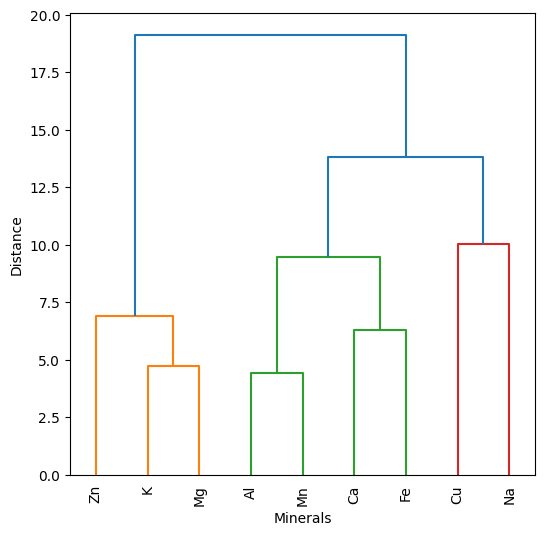

In [43]:
# 行列を転置して、ミネラルの相互関係を分析する
X_scaled_T = X_std.T

# 階層的クラスター分析 (HCA) の実行
# linkage関数を使用して「Ward」法と「ユークリッド」距離でクラスタリング
Z = linkage(X_scaled_T, method='ward', metric='euclidean')

# 樹状図（デンドログラム）の作成
plt.figure(figsize=(6, 6))
dendrogram(Z, labels=minerals, leaf_rotation=90, leaf_font_size=10)

# タイトルと軸のラベルを設定
plt.xlabel('Minerals')
plt.ylabel('Distance')

plt.show()

### 3.4 ミネラル成分に関する主成分分析

In [44]:
# 主成分分析 (PCA) の実行
pca = PCA(n_components=2)  # 最初の2つの主成分を抽出
principal_components = pca.fit_transform(X_scaled_T)

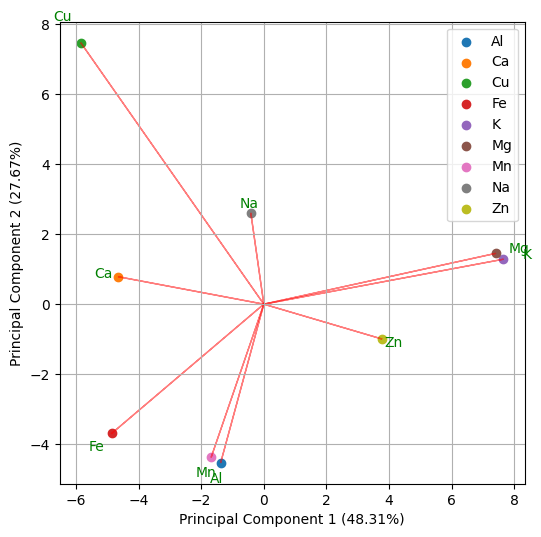

In [45]:
# バイプロットの作成
plt.figure(figsize=(6, 6))

# 各ミネラルのプロット
for i, mineral in enumerate(minerals):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], label=mineral)

# 主成分軸の矢印を描画
for i, (x, y) in enumerate(principal_components):
    plt.arrow(0, 0, x, y, color='r', alpha=0.5)
    plt.text(x * 1.1, y * 1.1, minerals[i], color='g', ha='center', va='center')

# タイトルと軸のラベルを設定
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')

plt.grid()
plt.legend()
plt.show()